# Paper Informations

The paper that was implemented is "HeadGAN: One-shot Neural Head Synthesis and Editing".

It could be found at: https://arxiv.org/pdf/2012.08261.pdf

Code Authors: Ahmet Taha ALBAYRAK, Abdüllatif AĞCA

Implementation details: In the original work, a GAN consisting of AdaIN and SPADE layers with multiple
discriminators was used to produce high quality facial transformation between two images. This being
applied to a sequence of frames, a face, its orientation and mimics in a video is transferred to a static
image. To achieve this, the original work used 4 separate helper libraries (3 of them is neural) to extract features.
These are as follows:

1) Retinaface: To extract the facial landmarks and dense point cloud, the authors used this as a feature extractor.
   Although it successfully extracts landmarks, the version that is shared online cannot extract the dense point cloud.
   We failed to find that version just like many other researcher failed to do so, according to the forums discussions at
   github.
2) LSFM: This library is used to align one face dense point cloud to another face's point cloud. This is required for
   facial transfer but since we failed to find Retinaface's related version, we used another library instead of these two combined.

2.5) 3DDFA V2: Because of the lack of Retinaface point cloud extraction, we decided to do it with the help of another library,
which is 3DDFA V2. With the help of this library, facial alignment and shape feature extraction (transformation, expression, shape)
is done too. After extracting the related features, related point clouds were rendered as PNCC (Projected Normalized Coordinate Code),
which is essentially transforming all the vertices to fit inside [0, 1] range in all x, y and z axes. Then, these coordinates are
rendered as R, G and B. The final RGB image contains information about a face's 3D features.

3) pyAudioAnalysis: A library to extract features of audio files, just like energy, entropy, MFCC etc.
4) Deep Speech 2.0: A library to extract the words from an audio file.

# Paper Summary

HeadGAN is a GAN-based system that conditioning synthesis on facial geometry using 3D face representations that can be derived from driving videos and customized to the facial geometry of the reference image,y. They make use of prior understanding of identity and expression disentanglement, contained within 3D morphable models (3DMMs). Pre-processing involves reconstructing the image first, then, after modifying the identity parameters, rendering the 3D face from the driving frame and the reference image. By using audio features as an additional input to HeadGAN, mouth movement is further enhanced.

## Preprocess 

## Overview of HeadGAN

<img src="images/overview.png" />

The dense flow network F computes a flow field for warping the reference image and features, according to the 3D face input. Then, the rendering network R uses this visual information along with the audio
features in order to translate the 3D face input into a photo-realistic image of the source.

## Dense flow networks

<img src="images/F.png" width="500"/>

High-quality visual elements that accurately depict the appearance of the source identity are essential to the rendering network R. However,it observed that simply using an encoder to extract such features from the reference image $y_{ref}$
is not sufficient. The reason is that the encoder is not able to extract the features that are necessary to accurately render the 3D face. In order to do that, they combined the reference picture with its corresponding 3D face ($y_{ref}$, $z_{ref}$), then run that combination through an encoder to extract visual feature maps in three spatial scales ($h^1$, $h^2$, $h^3$) that describe the appearance of the source identity. Then,
a decoder predicts the flow wt, guided by the driving 3D
face representation $x_{t−k:t}$, which is injected into F through SPADE blocks. By applying the flow field on each visual feature map, we obtain
the warped visual features($h^1_t$, $h^2_t$, $h^3_t$)and the warped reference image $y_t^{ref}$ , all of which depend on the driving head pose at frame $t$.



## Rendering Network

<img src="images/R.png" width="500"/>

The core of the network is the rendering network which aim to generate photo-realistic images from the driving 3D representation and the visual features.
As an input, the rendering network takes the driving 3D face representation $x_{t−k:t}$ and the visual features $h^1_t$, $h^2_t$, $h^3_t$ as inputs. The output is the rendered image $y_t$
Firstly, these inputs are fed into an encoder to get a latent space representation. Then, the latent space representation is fed into the decoder to generate the rendered image.
The decoder consists of a series of SPADE and AdaIN layers. These adaptive normalization layers give a capability to adapt to inject visual features and audio features into the network respectively.
At the end of the decoder, the PixelSuffle layers are used to upsample the rendered image. The PixelSuffle layers are good at upsampling by protecting the quality of the rendered image.


## Discriminators 

<img src="images/D.png" width="200"/>

The discrimantor of the network is used to distinguish between the generated image and the reference image. Also, second discriminator is used for focusing on the only mouth area. In addion to that, the audio features are spatially replicated and fed into the discriminator with the cropped image channel-wise. Unfortunately in our implementation, due to the sound feature extraction being too slow and dataset being too large, we cancelled the sound feature extractor supplied Gaussian random data instead. There is a version in the paper without audio features, but it lacks AdaIN layers. We kept the AdaIN layers and replaced audio features with Gaussian random data.

## Training Objective

The generatork networks (F, R) are optimized jointly. They optimize generators by applying perceptual loss ($L^{VGG}_F$ , $L^{VGG}_G$) and pixel loss ($L^{L1}_F$ , $L^{L1}_G$). The discriminator networks (D) are optimized separately. They applied hinge loss ($L^{adv}_G$) along wih feature matching loss  ($L^{FM}_G$) to increase photo-realism of the results. Those losses are;

$L^{VGG}_G = E_{p_{data}} \sum_{l} \left\|VGG_l(\tilde{y}) - VGG_l(y)\right\|_{1} $

$L^{L1}_G = E_{p_{data}} \left\|\tilde{y} - y\right\|_{1} $

$L^{adv}_G = -E_{p_{data}} D(x_t,\tilde{y}_t) + D_m(h_t^{(a)},\tilde{y}_t^m) $

$L^{adv}_D = -E_{p_{data}} min(0, -1 + D(x_t,y_t)) - min(0, -1 - D(x_t, \tilde{y}_t)) $

$L^{adv}_{D_m} = -E_{p_{data}} min(0, -1 + D(x_t,y_t^m)) - min(0, -1 - D(x_t, \tilde{y}^m_t)) $

$L_G = L^{adv}_G + \lambda_{L1}L^{L1}_G + \lambda_{VGG}L^{VGG}_G + \lambda_{FM}L^{FM}_G +  + \lambda_{L1}L^{L1}_F + \lambda_{VGG}L^{VGG}_F$

In the paper, the authors used the loss weights as $ \lambda_{L1} = 50 , \lambda_{VGG} = \lambda_{FM} = 10$:

$L_D = L^{adv}_D , L_{D_m} = L^{adv}_{D_m}$

## Qualitative Results

<img src="images/qualitative.png" width="800">

## Quantitative Results

<img src="images/quantitative.png" width="800">

## Conclusion




## Global Variables

In [1]:
from dataset import Face3dDataset
from torch.utils.data import DataLoader
import torch
import glob 

import os
from matplotlib import pyplot as plt
from training import training_loop
from training import evaluate_model
from headgan import HeadGAN
import numpy as np

## Training Hyperparameters

In [14]:
train_filelist = list(glob.iglob("data/train/mp4/" + '**/*.mp4', recursive=True))
test_filelist = list(glob.iglob("data/test/mp4/" + '**/*.mp4', recursive=True))
training_batch_size = 16
test_batch_size = 4
train_dataset = Face3dDataset(train_filelist, training_batch_size, is_gpu=False)
test_dataset = Face3dDataset(test_filelist, test_batch_size, is_gpu=False)

train_dataset = train_dataset
test_dataset = test_filelist
batch_size = 1
epochs = 10
step_size = 200
lr = 0.001
beta1 = 0.5
beta2 = 0.999
use_cuda = True if torch.cuda.is_available() else False
log_dir = "logs"
model_dir = "models"
model_name = "model"
num_workers = 1
checkpoint = None
checkpoint_epoch = None

## Training and Saving the Model

Due to very long training time, Juptyer notebooks are not recommended to be used for training. We recommend using a tmux server to train. The time it takes to train the model 1 epoch is around 16 hour using 3x Quadro RTX 8000.

In [ ]:
training_loop(train_dataset, test_dataset, batch_size, epochs,step_size,  lr, beta1, beta2, use_cuda, log_dir, model_dir, model_name, num_workers)

## Resuming training from a checkpoint

Similar to training from scratch, we recommend using a tmux server to resume training.

In [ ]:
train_dataset = train_dataset
test_dataset = test_dataset
batch_size = 1
epochs = 10
step_size = 200
lr = 0.001
beta1 = 0.5
beta2 = 0.999
use_cuda = True if torch.cuda.is_available() else False
log_dir = "logs"
model_dir = "models"
model_name = "model"
num_workers = 0
checkpoint = "models/model"
checkpoint_epoch = 0
checkpoint_step = 200

training_loop(train_dataset, test_dataset, batch_size, epochs, step_size, lr, beta1, beta2, use_cuda, log_dir, model_dir, model_name, num_workers, checkpoint, checkpoint_step, checkpoint_epoch )


## Load the saved model and compute qualitative results


In [ ]:
test_filelist = list(glob.iglob("data/test/mp4/" + '**/*.mp4', recursive=True))
test_batch_size = 1
test_dataset = Face3dDataset(test_filelist, test_batch_size, is_gpu=False)
test_loader = DataLoader(test_dataset, 4, shuffle=True, num_workers=0)


device = "cpu"
model = HeadGAN()
model = torch.nn.DataParallel(model)

model_path = "models/model.pth"
model.load_state_dict(torch.load(model_path, map_location=device))
model = model.module.to(device)

data, labels, unnormalized = next(iter(test_loader))
ref_image = data[0].reshape(-1, 256, 256, 3).permute(0, 3, 1, 2).to(device)
ref_3d_face = data[1].reshape(-1, 256, 256, 3).permute(0, 3, 1, 2).to(device)
face_3d = data[2].reshape(-1, 3, 256, 256, 3).permute(0, 1, 4, 2, 3).to(device)
audio_features = data[3].reshape(-1,1,300).to(device)
labels = labels.reshape(-1, 256, 256, 3).permute(0, 3, 1, 2).to(device)




original_ref_image = unnormalized[0][0].reshape(-1, 256, 256, 3).permute(0, 3, 1, 2).to(device)
original_ref_3d_face = unnormalized[1][0].reshape(-1, 256, 256, 3).permute(0, 3, 1, 2).to(device)
original_labels = unnormalized[4][0].reshape(-1, 256, 256, 3).permute(0, 3, 1, 2).to(device)

genareated_face, loss = model(ref_image, ref_3d_face, face_3d, audio_features, labels)

#### Qualitative Results

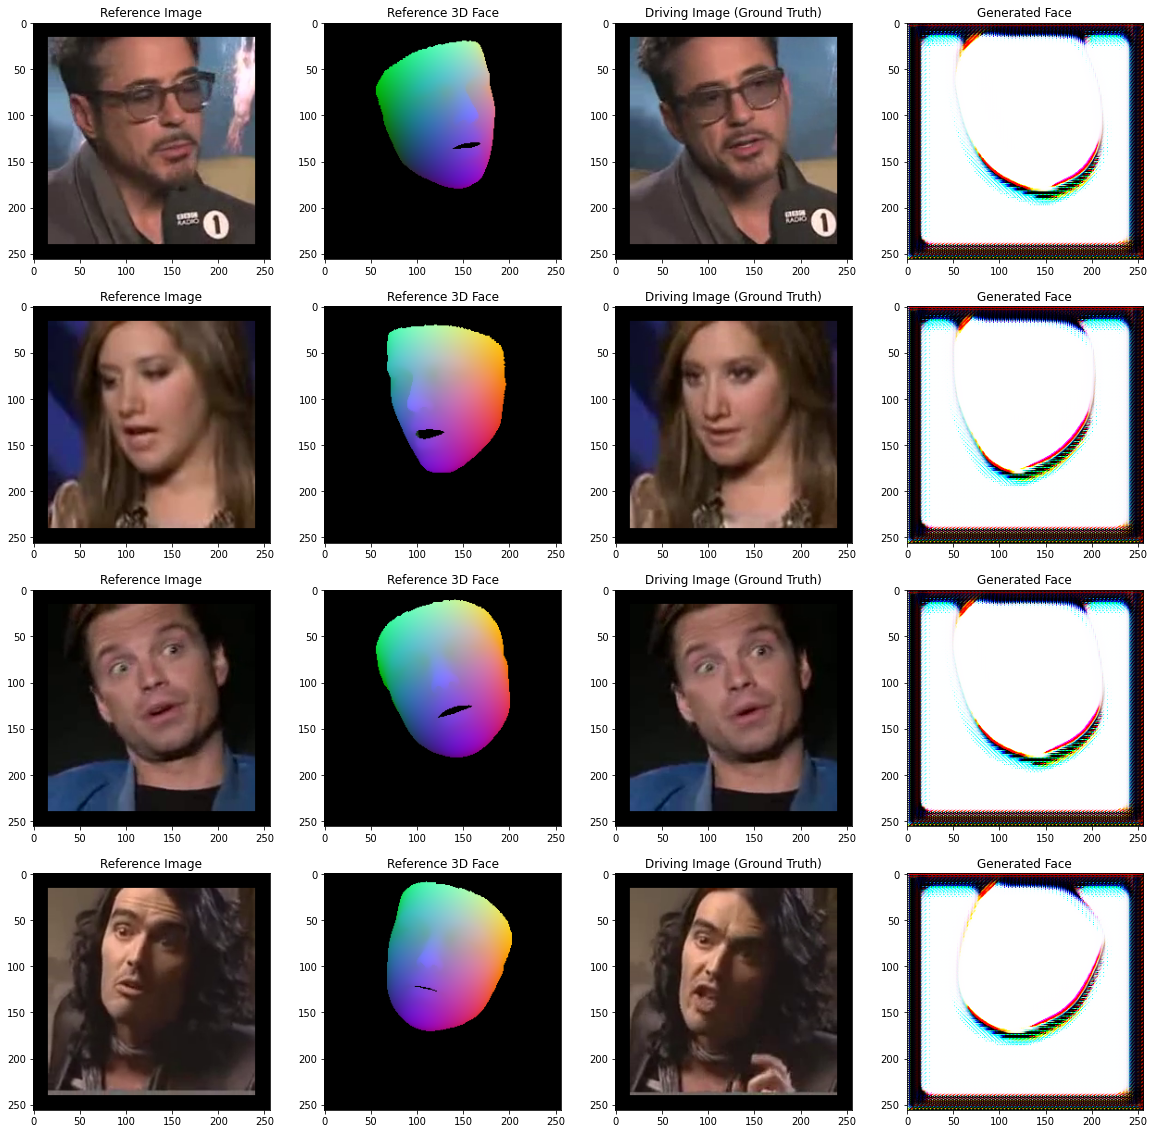

In [3]:
fig, ax = plt.subplots(4, 4, figsize=(20, 20))
for i in range(4):
    ax[i][0].imshow(original_ref_image[i].permute(1, 2, 0).cpu().detach().numpy().astype(np.uint8))
    ax[i][1].imshow(original_ref_3d_face[i].permute(1, 2, 0).cpu().detach().numpy().astype(np.uint8))
    ax[i][2].imshow(original_labels[i].permute(1, 2, 0).cpu().detach().numpy().astype(np.uint8))
    ax[i][3].imshow(genareated_face[i].permute(1, 2, 0).cpu().detach().numpy().clip(0, 1));
    ax[i][0].set_title("Reference Image")
    ax[i][1].set_title("Reference 3D Face")
    ax[i][2].set_title("Driving Image (Ground Truth)")
    ax[i][3].set_title("Generated Face")

plt.show()


#### Quantative Results

In [ ]:
scores = evaluate_model(model, test_loader, device, n_test_samples=10)

In [6]:
from tabulate import tabulate
table = [['','PSNR', 'FID'], ["Our Implementatiaon", scores['psnr'], scores['fid']], ["Original Implementation", 21.46, 36.1]]
print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))

╒═════════════════════════╤══════════╤═════════╕
│                         │     PSNR │     FID │
╞═════════════════════════╪══════════╪═════════╡
│ Our Implementatiaon     │  9.21557 │ 99915.1 │
├─────────────────────────┼──────────┼─────────┤
│ Original Implementation │ 21.46    │    36.1 │
╘═════════════════════════╧══════════╧═════════╛


## Tensorboard Charts for Losses

The following charts show the training adventure of the discriminators and the generator. While the discriminator seems to start doing a good job, the generator obviously oscillates between specific values and fails to learn. Unfortunately, we couldn't sort it out. There are several probabilities for this:
1) The visual feature extractor Retinaface's related version is not found online, so another library (3DDFA_V2) has been used for visual feature extraction. Although they seem to be the same as the Retinaface + LSFM does, these features may have slight differences. Although this is a very low probability, it is different from the paper and hence important to note.
2) Using AdaIN layers without audio features (but with random data as the modulation) may not have worked well. We thought it would bring stability this way but it may have brought even more trouble.

<img src="images/tensorboard.png"/>

While the charts show that the generator doesn't seem to be learning, maybe we didn't train it enough. This might be the case too. Unfortunately, the model + data was too big to fit on a regular computer, we had to do it with a more powerful one but we couldn't use it for too long unfortunately. That may be the problem too.

## Challanges

The 3D feature extraction (first 2.5 steps) are performed on-the-fly while training the network. However, since the
audio feature processing takes a significant amount of time, we decided to perform it offline then read the results
online. Unfortunately, because only the audio dataset is around 90GBs, sound preprocessing did not finish at a
reasonable time, so we decided to implement the code without sound features, which is also another version of the
same network in the same paper. However, unlike their without audio implementation, we didn't remove AdaIN layers, we just provided Gaussian random data instead.

Another challange is the required GPU memory. Even if we use 3 GPUs each has 48 gb, the memory usage is still very high, Although the model size is small (around ~800mb), the memory usage is still high. We used 16 batch size and a batch size of 16 is not enough to train the model just one epoch in a reasonable time (4 days). Therefore, the results are obviously not close to results in the original paper. The model memory usage is also not the only reason why the training time is so long. Another reason is that the training dataset VoxCeleb2 is a huge dataset and it contains around 1k person and 1m videos. Therefore, the training time is also dependent on the dataset size, the model memory footprint and very complicated preprocess.

In version 2, we will add sound features to the model to get better results and try to minimize memory footprint by doing making model smaller. In v1, our model can produce a very high level features such as shape. We strongly believed that the training time is not enough to produce good results. Therefore, we decided to train the model using low resolution.


